In [27]:
import os
import torch
import train
import ml4gw
import train.priors
import train.data.datasets.flow
import train.data.waveforms.generator.cbc
import ml4gw.nn.resnet.resnet_1d 
import ml4gw.nn.norm
import ml4gw.waveforms 
import ml4gw.distributions
import ml4gw.transforms
import ml4gw.dataloading
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
dec = ml4gw.distributions.Cosine()
psi = torch.distributions.Uniform(0, 3.14)
phi = torch.distributions.Uniform(-3.14, 3.14)
waveform_sampler = train.data.waveforms.generator.cbc.FrequencyDomainCBCGenerator(
    approximant=ml4gw.waveforms.IMRPhenomD(),
    f_min=20,
    f_max=1024,
    waveform_arguments={'f_ref': 40},
    num_test_waveforms=1,
    num_val_waveforms=1,
    parameter_sampler=train.priors.cbc_prior,
    num_fit_params=100000,
    inference_params=["chirp_mass", "mass_ratio", "distance", "phic",  "inclination", "dec", "psi", "phi"],
    sample_rate=2048,
    dec=dec,
    psi=psi,
    phi=phi, 
    duration=4,
    padding=0,
    ringdown_duration=0.5,
)

datamodule = train.data.datasets.flow.FlowDataset(
    data_dir=Path(os.environ["AMPLFI_DATADIR"]),
    inference_params=["chirp_mass", "mass_ratio", "distance", "phic",  "inclination", "dec", "psi", "phi"],
    highpass=25,
    sample_rate=2048,
    kernel_length=3,
    fduration=1,
    psd_length=10,
    fftlength=2,
    batches_per_epoch=1,
    batch_size=3,
    ifos=["H1", "L1"],
    min_valid_duration=10000.0,
    waveform_sampler=waveform_sampler,
)

2024-09-22 21:43:19,793 - root - INFO - Downloading data to /home/exouser/Documents/ligo/my-first-run/data


In [3]:
world_size, rank = datamodule.get_world_size_and_rank()
train_fnames, val_fnames = datamodule.train_val_split()
[background] = datamodule.load_background([train_fnames[0]])
datamodule._logger = datamodule.get_logger(world_size, rank)
datamodule.build_transforms("fit")
dataset = ml4gw.dataloading.InMemoryDataset(
                background,
                kernel_size=int(datamodule.hparams.sample_rate * datamodule.sample_length),
                batch_size=datamodule.hparams.batch_size,
                coincident=False,
                batches_per_epoch=datamodule.hparams.batches_per_epoch,
                shuffle=True,
            )
dataloader = torch.utils.data.DataLoader(
            dataset, num_workers=2
        )
[X] = next(iter(dataloader))
# X.to("cuda")

cross, plus, parameters = datamodule.waveform_sampler.sample(X)
strain, parameters = datamodule.inject(X, cross, plus, parameters)

2024-09-22 21:43:20,041 - AmplfiDataset - INFO - Building torch Modules and transferring to device
2024-09-22 21:43:20,044 - AmplfiDataset - INFO - Fitting standard scaler to parameters


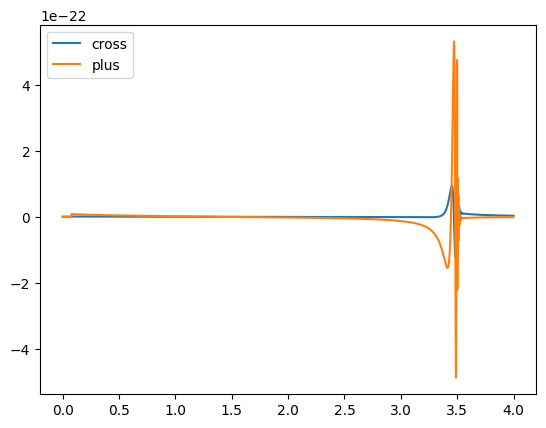

In [5]:
import numpy as np
time = np.arange(0, 4, 1/waveform_sampler.sample_rate)
plt.plot(time, cross[0], label="cross")
plt.plot(time, plus[0], label="plus")
# plt.xlim(2.4, 3.01)
plt.legend()

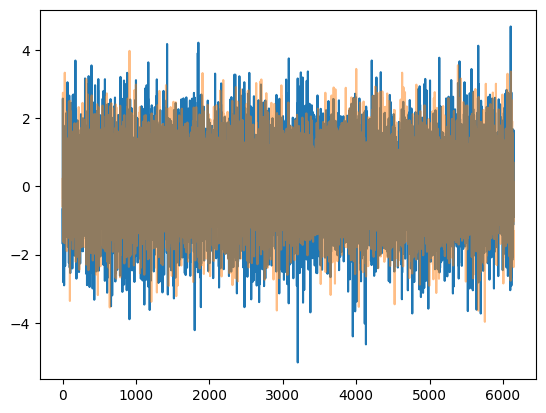

In [5]:
plt.plot(strain[0][0], label="L1")
plt.plot(strain[0][1], label="H1", alpha=0.5)

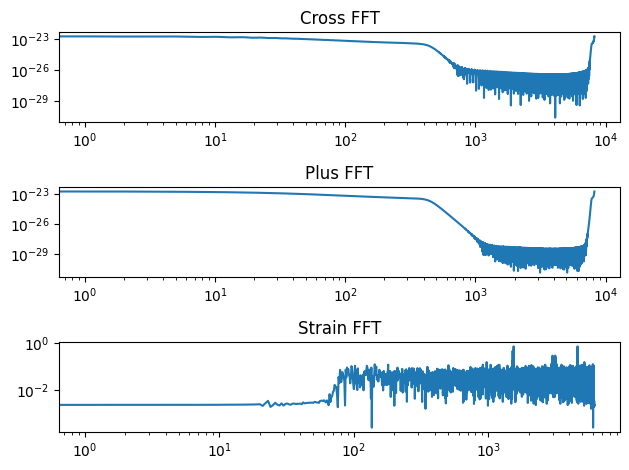

In [7]:
cross_fft = torch.fft.fft(cross[0]/waveform_sampler.sample_rate)
plus_fft = torch.fft.fft(plus[0]/waveform_sampler.sample_rate)
strain_fft = torch.fft.fft(strain/waveform_sampler.sample_rate)[0][0]
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(torch.abs(cross_fft))
plt.xscale("log")
plt.yscale("log")
plt.title("Cross FFT")
plt.subplot(3, 1, 2)
plt.plot(torch.abs(plus_fft))
plt.xscale("log")
plt.yscale("log")
plt.title("Plus FFT")
plt.subplot(3, 1, 3)
plt.plot(torch.abs(strain_fft))
plt.xscale("log")
plt.yscale("log")
plt.title("Strain FFT")
plt.tight_layout()
plt.show()

In [14]:
torch.stack([strain_fft.real, strain_fft.imag])

tensor([[-2.2332e-03, -2.2302e-03, -2.2338e-03,  ..., -2.2347e-03,
         -2.2338e-03, -2.2302e-03],
        [ 0.0000e+00, -1.8623e-05, -3.6881e-05,  ...,  5.5308e-05,
          3.6881e-05,  1.8623e-05]])

In [39]:
class MultiModal(torch.nn.Module):
    def __init__(
        self,
        num_ifos: int,
        context_dim: int,
        layers: list[int],
        kernel_size: int = 3,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        stride_type = None,
        norm_layer = None,
        **kwargs
    ):
        super().__init__()
        time_dims = context_dim // 2 if context_dim % 2 == 0 else context_dim // 2 + 1
        frequency_dims = context_dim // 2
        self.time_domain_resnet = ml4gw.nn.resnet.resnet_1d.ResNet1D(
            in_channels=num_ifos,
            layers=layers,
            classes=time_dims,
            kernel_size=kernel_size,
            zero_init_residual=zero_init_residual,
            groups=groups,
            width_per_group=width_per_group,
            stride_type=stride_type,
            norm_layer=norm_layer,
        )
        self.frequency_domain_resnet = ml4gw.nn.resnet.resnet_1d.ResNet1D(
            in_channels=int(num_ifos * 2),
            layers=layers,
            classes=frequency_dims,
            kernel_size=kernel_size,
            zero_init_residual=zero_init_residual,
            groups=groups,
            width_per_group=width_per_group,
            stride_type=stride_type,
            norm_layer=norm_layer,
        )

    def forward(self, X):
        time_domain_embedded = self.time_domain_resnet(X)
        X_fft = torch.fft.fft(X)
        X_fft = torch.cat((X_fft.real, X_fft.imag), dim=1)
        frequency_domain_embedded = self.frequency_domain_resnet(X_fft)

        embedding = torch.concat(
            (time_domain_embedded, frequency_domain_embedded), dim=1
        )
        return embedding

In [47]:
m = MultiModal(2, 8, [5, 3, 3])
m(strain), m(strain).shape

(tensor([[ 0.2488, -0.3330, -0.1297,  0.0340,  0.1764, -0.3136,  0.1638, -0.6806],
         [ 0.2591, -0.3374, -0.1213,  0.0418,  0.1980, -0.3309,  0.1517, -0.6858],
         [ 0.2513, -0.3549, -0.1283,  0.0472,  0.1962, -0.3328,  0.1612, -0.7448]],
        grad_fn=<CatBackward0>),
 torch.Size([3, 8]))